In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
import re
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer  # Correctly import PorterStemmer
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
string.punctuation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

stop_words = set(stopwords.words('english'))
english_words = set(words.words())
stemmer = PorterStemmer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
id2label = {i: label for i, label in enumerate(['Cancer', 'High_Bp', 'Diabetes'])}
from transformers import BloomConfig, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import nltk

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")

# Define config with num_labels
config = BloomConfig.from_pretrained("bigscience/bloom-560m")
config.update({"id2label": id2label, "num_labels": len(id2label)})

# Define the data loader
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are 1D tensors
        return item

    def __len__(self):
        return len(self.labels)

# Read and preprocess the dataset
df = pd.read_csv('/content/drive/MyDrive/FinalADR(1).csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna()
df.head()

# Define preprocess function
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word in english_words]
    return ' '.join(tokens)  # Convert tokens back to a single string

# Apply preprocessing to the text column
df['Clean'] = df['text'].apply(preprocess)

# Encode labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['disease'])

X=df.Clean
Y=df.label
# Initial split into train and temp (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.33, random_state=42)

# Further split temp into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.225, random_state=42)
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()
# Tokenize the data
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=170)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=170)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=170)

train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

# Load the model for sequence classification



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bigscience/bloom-560m", config=config)

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=20,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=10,  # Logging more frequently to monitor progress
    save_steps=400,
    eval_steps=400,  # Evaluate every 50 steps
    eval_strategy="steps",  # Use eval_strategy instead of evaluation_strategy
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

In [ ]:
trainer.evaluate(train_dataset)

Step,Training Loss,Validation Loss,Accuracy
400,0.979800,1.498014,0.713311
800,0.647300,0.703349,0.767918
1200,0.856700,0.787102,0.839590
1600,0.344100,1.063231,0.860068
2000,0.472600,1.663762,0.849829
2400,0.202900,1.476578,0.846416
2800,0.167800,1.211456,0.856655
2970,0.021400,0.127480,0.977247


{'eval_loss': 0.127480149269104, 'eval_accuracy': 0.9772468714448237}

In [ ]:
trainer.evaluate(test_dataset)

Step,Training Loss,Validation Loss,Accuracy
400,0.979800,1.498014,0.713311
800,0.647300,0.703349,0.767918
1200,0.856700,0.787102,0.839590
1600,0.344100,1.063231,0.860068
2000,0.472600,1.663762,0.849829
2400,0.202900,1.476578,0.846416
2800,0.167800,1.211456,0.856655
2970,0.021400,1.100087,0.873883


{'eval_loss': 1.10008704662323, 'eval_accuracy': 0.8738828202581926}

In [ ]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

Step,Training Loss,Validation Loss,Accuracy
400,0.979800,1.498014,0.713311
800,0.647300,0.703349,0.767918
1200,0.856700,0.787102,0.839590
1600,0.344100,1.063231,0.860068
2000,0.472600,1.663762,0.849829
2400,0.202900,1.476578,0.846416
2800,0.167800,1.211456,0.856655
2970,0.021400,1.100087,0.873883


In [ ]:
import numpy as np

# Extract true labels
true_labels = predictions.label_ids

# Extract predicted labels (argmax over logits)
preds = np.argmax(predictions.predictions, axis=1)

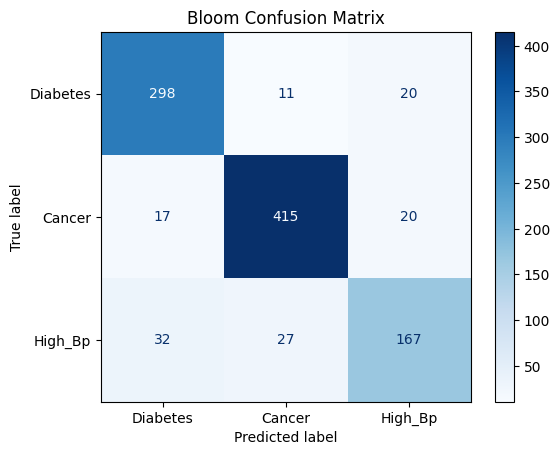

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['Diabetes', 'Cancer', 'High_Bp']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Bloom Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming true_labels and preds are already defined
print(classification_report(true_labels, preds, target_names=labels))

              precision    recall  f1-score   support

    Diabetes       0.86      0.91      0.88       329
      Cancer       0.92      0.92      0.92       452
     High_Bp       0.81      0.74      0.77       226

    accuracy                           0.87      1007
   macro avg       0.86      0.85      0.86      1007
weighted avg       0.87      0.87      0.87      1007



In [ ]:
# saving the fine tuned model & tokenizer
model_path = "/content/drive/MyDrive/Roberta"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
trainer.evaluate()